In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import sys
sys.path
sys.path.append('/home/jovyan/test_surge_models/surgeNN')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from surgeNN.io import load_predictand,load_predictors
import matplotlib.pyplot as plt

In [2]:
#setttings
tg        = 'den_helder-denhdr-nld-rws.csv' #site to predict
temp_freq = 3 #hours
n_steps   = 9 #number of timesteps at and before predictand to use predictors at
n_cells   = 5 #n x n grid cells around TG
batch_size = 128

predictors = load_predictors('/home/jovyan/test_surge_models/input/predictors_'+str(temp_freq)+'hourly',tg) #open predictor xarray dataset
predictors = predictors.sel(time=slice('1979','2017'))
#predictands
tgs = os.listdir('/home/jovyan/test_surge_models/input/t_tide_3h_hourly_deseasoned_predictands')
tgs = [k for k in tgs if '.csv' in k]

availability = []
lons = []
lats = []
for tg in tgs:
    predictand = load_predictand('/home/jovyan/test_surge_models/input/t_tide_'+str(temp_freq)+'h_hourly_deseasoned_predictands',tg) #open predictand csv
    predictand = predictand.set_index('date').resample(str(temp_freq)+'h').fillna(method=None) #insert nans where timesteps are missing
    predictand = predictand.reset_index()[['surge','date','lon','lat']]
    predictand = predictand[(predictand['date']>=predictors.time.isel(time=0).values) & (predictand['date']<=predictors.time.isel(time=-1).values)]  # only use predictands in the period for which we also have predictor values, including at preceding timesteps
    availability.append(np.sum(np.isfinite(predictand['surge']))/len(predictors.time))
 
    lons.append(predictand.lon.values[np.isfinite(predictand.lon.values)][0])
    lats.append(predictand.lat.values[np.isfinite(predictand.lat.values)][0])
     
[LON,LAT] = np.meshgrid(predictors.longitude,predictors.latitude)

lstm_example = xr.open_dataset('/home/jovyan/test_surge_models/results/nn_tests/performance/lstm/lstm_3h_den_helder-denhdr-nld-rws_mse_hp1_it0.nc')

In [3]:
#define subset of tide gauges
subset = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Stavanger (NOR)','Wick (UK)', 'Esbjerg (DK)','Immingham (UK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)','Vigo (PT)', 'Alicante (SP)']
idx_subset = np.array([np.where(np.array(tgs)==place)[0][0] for place in subset])

/srv/conda/envs/notebook/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


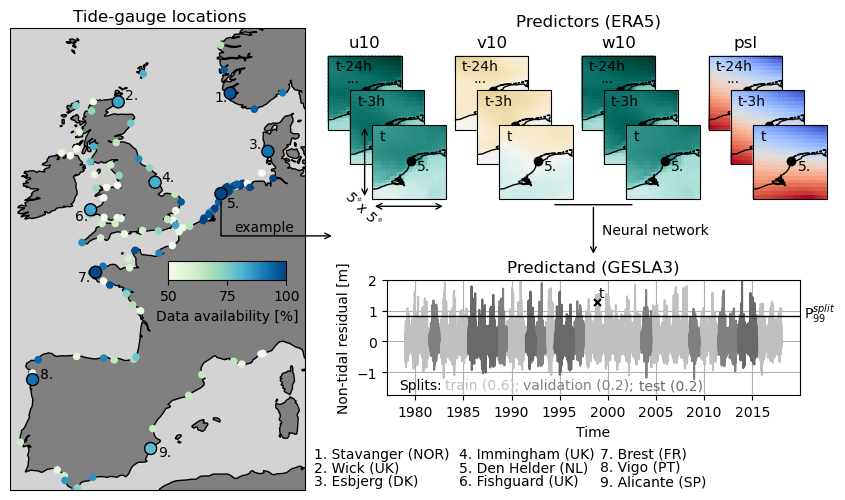

In [5]:
dx = [-1.3,.5,-1.4,.45,.45,-1.1,-1.3,.5,.5] #for plotting numbering
dy = [-.5,.15,.2,.1,-.8,-.6,-.5,.1,-.4]

fig=plt.figure(figsize=(5,6)) #generate figure  
gs = fig.add_gridspec(1,1)
gs.update(hspace=.2)

#-> subplot data availability
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(lons,lats,c=100*np.array(availability),cmap='GnBu',transform=ccrs.PlateCarree(),s=20,vmin=50,vmax=100,zorder=5) #colors
ax.scatter(np.array(lons)[idx_subset],np.array(lats)[idx_subset],c=100*np.array(availability)[idx_subset],cmap='GnBu',edgecolor='black',linewidth=1,transform=ccrs.PlateCarree(),zorder=10,s=75,vmin=50,vmax=100) #edge of selected locations
for i in np.arange(len(idx_subset)): #annotate locations & make legend
    ax.text(np.array(lons)[idx_subset[i]]+dx[i],np.array(lats)[idx_subset[i]]+dy[i],str(i+1)+'.',transform=ccrs.PlateCarree(),zorder=10,color='black')
    if i<3:
        ax.text(1.03,.07-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')
    if ((i>=3) & (i<6)):
        ax.text(1.52,.16-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')
    if i>=6:
        ax.text(2,.25-i*.03,str(i+1)+'. '+tgnames[i],transform=ax.transAxes,zorder=10,color='black')

#arrow with example at DH
ax.text(0.76,0.56,'example',transform=ax.transAxes,zorder=10,color='black')
ax.annotate('', xy=(0.715, 0.545), xytext=(0.715, 0.63),
            arrowprops=dict(facecolor='black', arrowstyle='-'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)
ax.annotate('', xy=(1.1, 0.55), xytext=(0.705, 0.55),
            arrowprops=dict(facecolor='black', arrowstyle='->'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)

sc.set_edgecolor('face')
ax.coastlines(zorder=1,color='black')
ax.set_extent([-10, 10, 36, 63], crs=ccrs.PlateCarree())
ax.text(.215,1.015,'Tide-gauge locations',transform=ax.transAxes,zorder=6,fontsize=12)

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.56, .47,.4,.04),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Data availability [%]')
 
#-> subplots predictors around Den Helder at time itime_disp
itime_disp = np.where(lstm_example.o.isel(i=0).sel(split='train')>np.nanpercentile(lstm_example.o.isel(i=0).sel(split='train'),99))[0][int(len(np.where(lstm_example.o.isel(i=0).sel(split='train')>np.nanpercentile(lstm_example.o.isel(i=0).sel(split='train'),99))[0])/2)]

for v,var in enumerate(['u10','v10','w','msl']):
    for i in np.arange(3):
        gax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1+i*.075+.43*v, .75-i*.075,.25,.25),bbox_transform=ax.transAxes,axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                     axes_kwargs=dict(map_projection=cartopy.crs.PlateCarree()))
        gax.coastlines(zorder=4,color='black')
        gax.scatter(np.array(lons)[idx_subset[4]],np.array(lats)[idx_subset[4]],facecolor='black',transform=ccrs.PlateCarree(),zorder=5)
        gax.text(np.array(lons)[idx_subset[4]]+.45,np.array(lats)[idx_subset[4]]-.65,'5.',transform=ccrs.PlateCarree(),zorder=5,color='black')
        gax.text(.1,.8,['t-24h','t-3h','t'][i],transform=gax.transAxes,zorder=6)
        if i==0:
            gax.set_title(['u10','v10','w10','psl'][v])
            gax.text(.25,.65,'...',transform=gax.transAxes,zorder=6)
        if var=='msl':
            p=gax.pcolor(LON,LAT,predictors[var].isel(time=itime_disp+i*2),transform=ccrs.PlateCarree(),cmap='coolwarm',zorder=1)
        else:
            p=gax.pcolor(LON,LAT,predictors[var].isel(time=itime_disp+i*2),transform=ccrs.PlateCarree(),cmap='BrBG',zorder=1,vmin=-20,vmax=20)
        if (var=='u10') & (i==2):
            gax.annotate('', xy=(-.1, 0), xytext=(-.1, 1),
            arrowprops=dict(facecolor='black', arrowstyle='<->'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)
            gax.annotate('', xy=(1, -.1), xytext=(0, -.1),
            arrowprops=dict(facecolor='black', arrowstyle='<->'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)
            gax.text(-.42,-.38,'5$^{\circ}$x 5$^{\circ}$',transform=gax.transAxes,zorder=6, rotation = -45)
            gax.text(1.95,2.35,'Predictors (ERA5)',transform=gax.transAxes,zorder=6,fontsize=12)
        p.set_edgecolor('face')
        
#-> subplot predictand
tax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.3, .22,1.4,.25),bbox_transform=ax.transAxes)
tax.annotate('', xy=(0.5,1.2), xytext=(0.5, 1.65),
            arrowprops=dict(facecolor='black', arrowstyle='->'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)
tax.annotate('', xy=(0.6, 1.65), xytext=(0.4, 1.65),
            arrowprops=dict(facecolor='black', arrowstyle='-'),xycoords='axes fraction',textcoords='axes fraction',zorder=20)

tax.text(0.52,1.4,'Neural network',transform=tax.transAxes,zorder=6)
tax.grid()
tax.plot(lstm_example.o.isel(i=0).sel(split='train').time,lstm_example.o.isel(i=0).sel(split='train'),color='silver')
tax.plot(lstm_example.o.isel(i=0).sel(split='val').time,lstm_example.o.isel(i=0).sel(split='val'),color='grey')
tax.plot(lstm_example.o.isel(i=0).sel(split='test').time,lstm_example.o.isel(i=0).sel(split='test'),color='dimgrey')
tax.axhline(y=np.nanpercentile(lstm_example.o.isel(i=0).sel(split='train'),99),linewidth=1,color='black',zorder=2)

tax.text(1.01,.66,'P$_{99}^{split}$',transform=tax.transAxes,zorder=6)
tax.scatter(lstm_example.isel(i=0).sel(split='train').time[itime_disp],lstm_example.isel(i=0).sel(split='train').o[itime_disp],color='black',zorder=5,s=25,marker='x')
tax.text(lstm_example.isel(i=0).sel(split='train').time[itime_disp+500],lstm_example.isel(i=0).sel(split='train').o[itime_disp]+.15,'t',color='black',zorder=5)
tax.text(0.03,.052,'Splits:',color='black',transform=tax.transAxes,zorder=5)
tax.text(.14,.052,'train (0.6);',color='silver',transform=tax.transAxes,zorder=5)
tax.text(.33,.052,'validation (0.2);',color='grey',transform=tax.transAxes,zorder=5)
tax.text(.61,.052,'test (0.2)',color='dimgrey',transform=tax.transAxes,zorder=5)
tax.set_ylabel('Non-tidal residual [m]')
tax.set_title('Predictand (GESLA3)')
tax.set_ylim([-1.75,2])
tax.set_xlabel('Time')

plt.savefig('fig1_regression_task.pdf', bbox_inches='tight',dpi=300,format='pdf')
